## Human Detection for WatchPoint devices

#### Introduction

The _WatchPoint_ company aims to provide state of the art security camera system: dedicated to keep every customer safe. This investigation is presented to follow the company's goal of bringing mayor innovation to their products. Conventional security cameras utilize motion detection in order to alert of possible break-ins; however, many factors can trigger this security measures and lead to false alarms. Not only is it inconvinient to the customer, but to the enterprise as well. To solve this issue, a deep learning model is proposed to diminish the amount of false positives. The cameras will load an image, after movement is detected, to the company's server. It will then analyze the picture using a CNN model and alert if a human is detected or not. This will make the system more reliable and efficient.

#### Image Analysis

Loading and viewing of the image dataset to train the model. This dataset was obtained through kaggle and consists of 921 images. These will be separated with a validation split of 0.2 and in batch size of 32. This was done to give a better training set to the models. The images are cropped to fit 480 x 480.

In [8]:
# Load required libraries
import numpy as np
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers
from keras.utils import image_dataset_from_directory, array_to_img
import keras.optimizers as optim
import keras.losses as loss
import keras.metrics as mtrc
import matplotlib.pyplot as plt

In [9]:
image = (480, 480) # Image size
image_size = (480, 480, 3) # Image size & color
batch = 32 # Batch size 
split = 0.2 # Percentage of validation
crop = True # Crop images or pad

In [10]:
dirImages = "/kaggle/input/human-detection-dataset/human detection dataset" # Directory

train = image_dataset_from_directory(
    dirImages,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=batch,
    image_size=image,
    shuffle=True,
    seed=333,
    validation_split=split,
    subset="training",
    interpolation="nearest",
    follow_links=False,
    crop_to_aspect_ratio=crop,
    pad_to_aspect_ratio=(not crop),
    data_format=None,
    verbose=True,
)

test = image_dataset_from_directory(
    dirImages,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=batch,
    image_size=image,
    shuffle=True,
    seed=333,
    validation_split=split,
    subset="validation",
    interpolation="nearest",
    follow_links=False,
    crop_to_aspect_ratio=crop,
    pad_to_aspect_ratio=(not crop),
    data_format=None,
    verbose=True,
)

Found 921 files belonging to 2 classes.
Using 737 files for training.
Found 921 files belonging to 2 classes.
Using 184 files for validation.


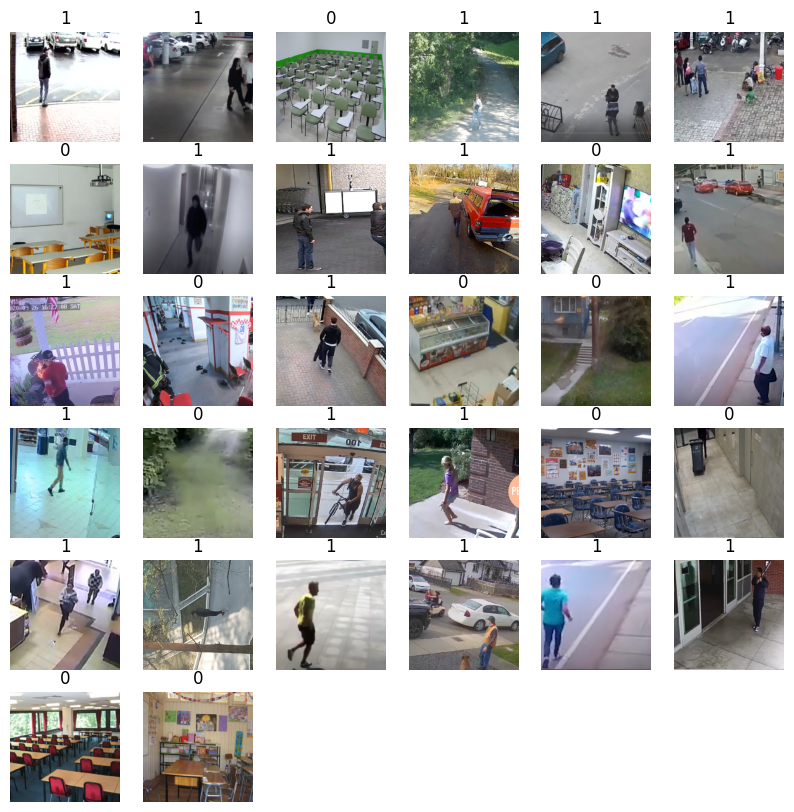

In [11]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train.take(1).unbatch()):
    ax = plt.subplot(6, 6, i + 1)
    image = array_to_img(image)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

#### Data Augmentation

The images are then passed through data augmentation in order to expand the dataset and prevent overfitting. A simple random flip and zoom is applied so that the model can be robust in different positions the camera may be in.

In [12]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(0.2)
])

#### CNN model

Here a conventional CNN model is implemented. It has 5 layers at which the model extracts the most important features using convolutions, batch normalization and max pooling. Higher kernels were used at the beginning to expand the filter and traverse the images faster so as to focus more on the smaller details of the people present in the image afterwards. 

In [13]:
model1 = keras.Sequential([
    
    # Input images and data augmentation
    keras.Input(shape=image_size),
    data_augmentation,

    # First layer of convolution, normalization and pooling
    layers.Conv2D(filters=32,kernel_size=5,activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Second layer of convolution, normalization and pooling
    layers.Conv2D(filters=64,kernel_size=5,activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Third layer of convolution, normalization and pooling
    layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Fourth layer of convolution, normalization and pooling
    layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Fifth layer of convolution, normalization and pooling
    layers.Conv2D(filters=512, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=2),

    # Average pooling for flattening
    layers.GlobalAveragePooling2D(),

    # Fully connected NN layer
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.25), 
    layers.Dense(1, activation="softmax")
])

model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 480, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 476, 476, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 476, 476, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 234, 234, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 234, 234, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 117, 117, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 115, 115, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 115, 115, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 57, 57, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 55, 55, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 55, 55, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 25, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,672,641 (6.38 MB)

 Trainable params: 1,670,657 (6.37 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [14]:
# Training characteristics
model1.compile(
    optimizer=optim.Adam(),
    loss=loss.BinaryCrossentropy(from_logits=False),
    metrics=[mtrc.BinaryAccuracy(), mtrc.Precision(), mtrc.Recall()],
)

# Training the model
model1.fit(train, epochs=5)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 571s 24s/step - binary_accuracy: 0.5791 - loss: 0.9302 - precision_1: 0.5791 - recall_1: 1.0000
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 530s 22s/step - binary_accuracy: 0.5930 - loss: 0.7005 - precision_1: 0.5930 - recall_1: 1.0000
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 570s 24s/step - binary_accuracy: 0.5790 - loss: 0.6540 - precision_1: 0.5790 - recall_1: 1.0000
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 568s 24s/step - binary_accuracy: 0.5975 - loss: 0.6864 - precision_1: 0.5975 - recall_1: 1.0000
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 561s 23s/step - binary_accuracy: 0.5970 - loss: 0.5966 - precision_1: 0.5970 - recall_1: 1.0000


In [15]:
model1.evaluate(test) # Test the model

6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - binary_accuracy: 0.6534 - loss: 1.5630 - precision_1: 0.6534 - recall_1: 1.0000


[1.5144020318984985, 0.635869562625885, 0.635869562625885, 1.0]

#### Transfer learning CNN model

A pre-trained model is tested to see if it achieves a higher performance. This implementation will use the base model for imagenet, which requires a rescaling of the image before processing. The base model is first frozen so as to prevent it from overfitting while the last dense layer is trained. A higher amount of epochs is in this first stage to train the model well enough, for then to unfreeze the base and train both models one last time.

In [16]:
# Load a convolutional base with pre-trained weights
base_model = keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=image_size,
    pooling='avg'
)

# Freeze the base model
base_model.trainable = False

# Transfer learning model
model2 = keras.Sequential([
    keras.Input(shape=image_size),
    layers.Rescaling(scale=1 / 127.5, offset=-1),
    base_model,
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Show model
model2.summary(show_trainable=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ rescaling (Rescaling)       │ (None, 480, 480, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 2048)          │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [17]:
# Training characteristics
model2.compile(
    optimizer=optim.Adam(),
    loss=loss.BinaryCrossentropy(from_logits=False),
    metrics=[mtrc.BinaryAccuracy(), mtrc.Precision(), mtrc.Recall()],
)

# Training the model
model2.fit(train, epochs=3)

Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 464s 19s/step - binary_accuracy: 0.6808 - loss: 0.6191 - precision_2: 0.6656 - recall_2: 0.9566
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 425s 18s/step - binary_accuracy: 0.7377 - loss: 0.5273 - precision_2: 0.7134 - recall_2: 0.9500
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 454s 19s/step - binary_accuracy: 0.7964 - loss: 0.4800 - precision_2: 0.7709 - recall_2: 0.9344


In [18]:
# Unfreeze the base model
base_model.trainable = True

# Show model
model2.summary(show_trainable=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ rescaling (Rescaling)       │ (None, 480, 480, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 2048)          │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

In [19]:
# Training characteristics
model2.compile(
    optimizer=optim.Adam(),
    loss=loss.BinaryCrossentropy(from_logits=False),
    metrics=[mtrc.BinaryAccuracy(), mtrc.Precision(), mtrc.Recall()],
)

# Training the model
model2.fit(train, epochs=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1795s 73s/step - binary_accuracy: 0.8592 - loss: 0.3227 - precision_3: 0.8388 - recall_3: 0.9485


In [20]:
model2.evaluate(test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 109s 18s/step - binary_accuracy: 0.7642 - loss: 13.3990 - precision_3: 0.7313 - recall_3: 0.9882


[14.390310287475586, 0.760869562625885, 0.7295597195625305, 0.9914529919624329]

#### Results

After training with different models, the one with the best metrics was the one using transfer learning with higher metrics overall. One thing that seems odd in the conventional CNN model is that it maintained its recall at 1, which shows a bias towards false negative classification rather than false positive.

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


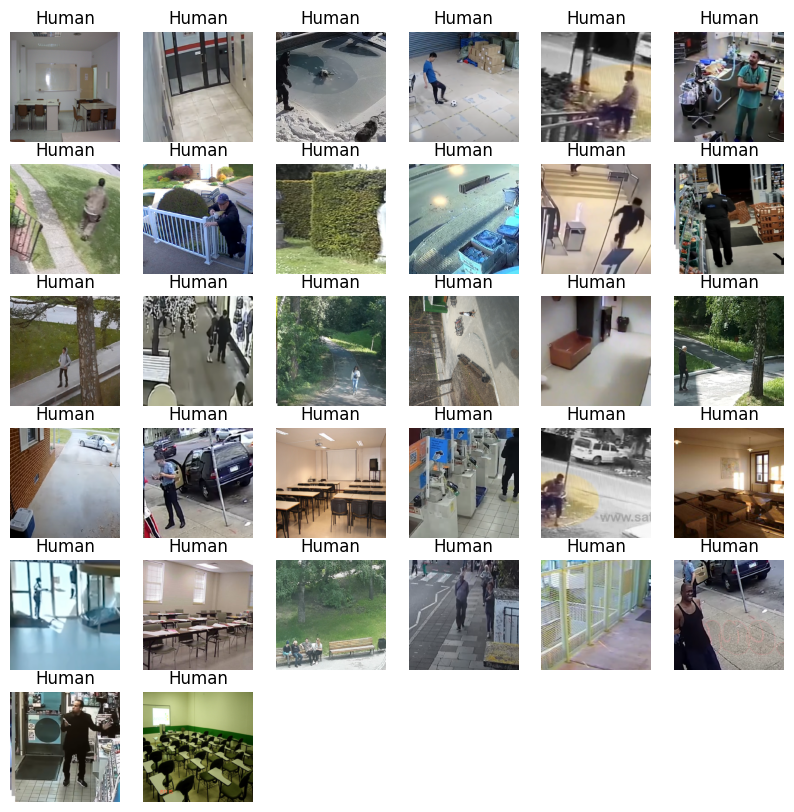

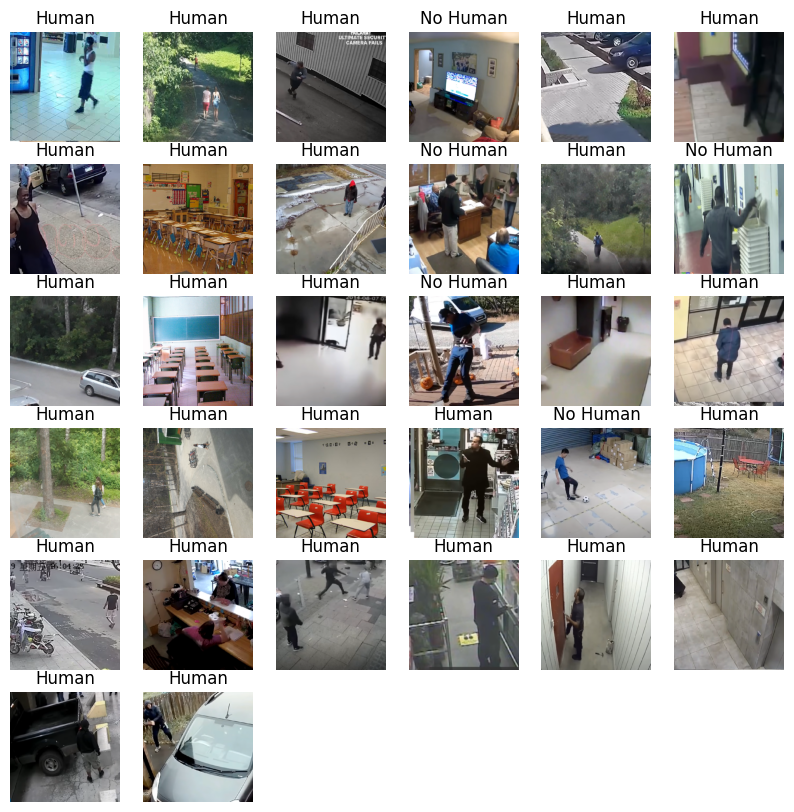

In [22]:
testBatch = test.take(1)
predBatch1 = model1.predict(testBatch)
predBatch2 = model2.predict(testBatch)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(testBatch.unbatch()):
    ax = plt.subplot(6, 6, i + 1)
    image = array_to_img(image)
    plt.imshow(image)
    if predBatch1[i][0] > 0.5:
        plt.title("Human")
    else:
        plt.title("No Human")
    plt.axis("off")

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(testBatch.unbatch()):
    ax = plt.subplot(6, 6, i + 1)
    image = array_to_img(image)
    plt.imshow(image)
    if predBatch2[i][0] > 0.5:
        plt.title("Human")
    else:
        plt.title("No Human")
    plt.axis("off")

#### Conclusion

Summing up, the tests were successful in showing the transfered learning model to be the best alternative for this implementation. In general, the model still needs more work before being fully added onto production. More tests with other types of pretrained models or implementing other types of CNN implementations like RCNN or YOLO.

En general aprendí mucho del reconocimiento de humanos y encontré mucha información sobre ello. Me tomó mucho tiempo el poder cargar correctamente a las imagenes debido a unos problemas con los colores, y también me tomó mucho tiempo el entrenar los modelos por tener tantos pixeles, pero quería tomarme el tiempo para que sea lo más apegado a una cámara real.